<a href="https://colab.research.google.com/github/AmoguJUduka/MachineLearning/blob/main/PersonalProjects/MazeProject_ECE651.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install necessary packages

In [1]:
!pip install mazelib
!pip install pillow
!pip install urllib3
!pip install scikit-image

Import necessary libraries and packages

In [2]:
# mazelib API
from mazelib import Maze
from mazelib.generate.Prims import Prims
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import argparse




Helper functions

In [3]:
def MazeGenerator(M=20,N=8):
    """ N is the size"
    M is the number of samples
    """
    mazes = [] # Fixed: Removed extra indentation
    for i in range(M):
        m = Maze()
        m.generator = Prims(N, N)  # creation of N x N maze
        m.generate()
        mazes.append(m)
    return mazes



# Visualize the maze
def VisualizeMaze(grid):
    plt.figure(figsize=(5, 5))
    plt.imshow(grid, cmap="binary")
    plt.axis("off")
    plt.title("8x8 Maze Generated with Prim's Algorithm")
    plt.show()



# Parameters
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=400, help="interval between image sampling")

import sys
# Convert numerical arguments to strings
sys.argv = ['ipython-input-15-',
           '--n_epochs', '1',
           '--batch_size', '40',
           '--lr', '0.001',
           '--b1', '0.5',
           '--b2', '0.999',
           '--n_cpu', '8',
           '--latent_dim', '100',
           '--img_size', '32',
           '--channels', '1',
           '--sample_interval', '400']
# Now sys.argv contains only strings


opt = parser.parse_args()

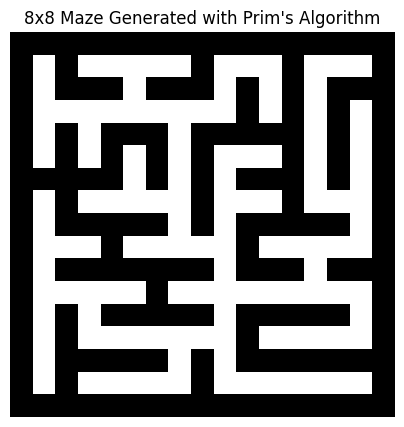

In [4]:
mazes = MazeGenerator()
VisualizeMaze(mazes[0].grid)

The grid attribute of the maze contains a 2D array representing the maze, where



*   **1** indicates walls
*   **0** indicates open paths



Transforming the Maze Dataset

In [5]:
class MazeDataset(Dataset):
    def __init__(self, mazes, transform=None):
        self.mazes = mazes
        self.transform = transform

    def __len__(self):
        return len(self.mazes)

    def __getitem__(self, idx):
        maze = self.mazes[idx]
        maze_array = np.array(maze.grid, dtype=np.float32)
        maze_tensor = torch.FloatTensor(maze_array)
        maze_tensor = maze_tensor.unsqueeze(0)

        if self.transform:
            maze_tensor = self.transform(maze_tensor)

        return maze_tensor

# Create transforms
transform = transforms.Compose([
    transforms.Normalize([0.5], [0.5])
])


maze_dataset = MazeDataset(mazes, transform=transform)

# Create dataloader
dataloader = DataLoader(
    maze_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2
)

In [6]:
os.makedirs("images", exist_ok=True)

Check to see if the runtime uses a GPU or CPU (GPU is preferred due to its parallel procesiing capability)

In [7]:
cuda = True if torch.cuda.is_available() else False

In [8]:
cuda

True

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

This function initializes the weights of a neural network's layers using a normal distribution, specifically targetting convolutional layers and batch normalization layers in a PyTorch model.

This initialization is particularly recommended in the DCGAN paper (Deep Convoluitonal Generative Adversarial Networks).

In [10]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

Generator Class

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.init_size = 2  # size of maze // 4 = 2

        # First layer transforms noise to 2x2x128 feature map
        self.l1 = nn.Sequential(
            nn.Linear(opt.latent_dim, 128 * self.init_size ** 2)
        )

        # Convolutional blocks to generate maze
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),

            # First upsampling: 2x2 -> 4x4
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            # Second upsampling: 4x4 -> 8x8
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            # Final convolution to get binary maze
            nn.Conv2d(64, 1, 3, stride=1, padding=1),  # 1 channel for binary maze
            nn.Sigmoid()  # Use Sigmoid instead of Tanh for binary output (0 or 1)
        )

    def forward(self, z):
        # Generate initial feature map
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        # Generate maze
        maze = self.conv_blocks(out)
        return maze

Discriminator Class

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [
                nn.Conv2d(in_filters, out_filters, 3, stride=2, padding=1),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout2d(0.25)
            ]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(1, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
        )


        ds_size = 1

        # Final classification layer
        self.adv_layer = nn.Sequential(
            nn.Linear(64 * ds_size * ds_size, 1),  nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        return validity

In [13]:
adversarial_loss = torch.nn.BCELoss()  # Loss Function

#Initialize Generator and Discriminator
generator = Generator()
generator = generator.to(device)

discriminator = Discriminator()
discriminator = discriminator.to(device)

In [14]:
# Initialize weights
generator.apply(weights_init_normal)

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Sigmoid()
  )
)

In [15]:
# Initialize weights
discriminator.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (adv_layer): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [16]:
# Parameters
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=400, help="interval between image sampling")

import sys
# Convert numerical arguments to strings
sys.argv = ['ipython-input-15-',
           '--n_epochs', '1',
           '--batch_size', '40',
           '--lr', '0.001',
           '--b1', '0.5',
           '--b2', '0.999',
           '--n_cpu', '8',
           '--latent_dim', '100',
           '--img_size', '32',
           '--channels', '1',
           '--sample_interval', '400']
# Now sys.argv contains only strings


opt = parser.parse_args()

In [17]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [18]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Training of Model

In [19]:
# Modified training loop for maze generation
for epoch in range(opt.n_epochs):
    for i, data in enumerate(dataloader):
        mazes = data[0]
        batch_size = mazes.size(0)

        # Ground truths
        valid = Variable(Tensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_mazes = Variable(mazes.type(Tensor))

        # Train Generator
        optimizer_G.zero_grad()
        z = Variable(Tensor(np.random.normal(0, 1, (batch_size, opt.latent_dim))))
        gen_mazes = generator(z)

        # Add maze-specific constraints here if needed
        # e.g., connectivity check, wall thickness, etc.

        g_loss = adversarial_loss(discriminator(gen_mazes), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_mazes), valid)
        fake_loss = adversarial_loss(discriminator(gen_mazes.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Print progress
        if i % 100 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %.4f] [G loss: %.4f]"
                % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )

        # Save sample mazes
        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            # Convert to binary (0 or 1) before saving
            sample_mazes = (gen_mazes.data[:9] > 0.5).float()
            save_image(sample_mazes, f"images/{batches_done}.png", nrow=3, normalize=True)

<ipython-input-19-65e5e02b589f>:8: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  valid = Variable(Tensor(batch_size, 1).fill_(1.0), requires_grad=False)


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 64, 1, 1])

**References**


1.   https://github.com/john-science/mazelib/blob/main/docs/API.md
2.   List item


